In [11]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.patches as mpatches
from PIL import Image
import numpy as np
import random

categories = ["background", "avalanche",
              "building_undamaged", "building_damaged",
              "cracks/fissure/subsidence", "debris/mud/rock flow",
              "fire/flare", "flood/water/river/sea",
              "ice_jam_flow", "lava_flow",
              "person", "pyroclastic_flow",
              "road/railway/bridge", "vehicle"]

colors = ['black', 'white', 'pink', 'yellow', 'orange', 'brown',
          'red', 'blue', 'navy', 'orange', 'cyan', 'gray',
          'magenta']

filepath = "/home/pappol/Scrivania/uni/cv/low_power_segmentation/dataset/LPCVC_Train_Updated/LPCVC_Train_Updated/LPCVC_Train_Updated"


392


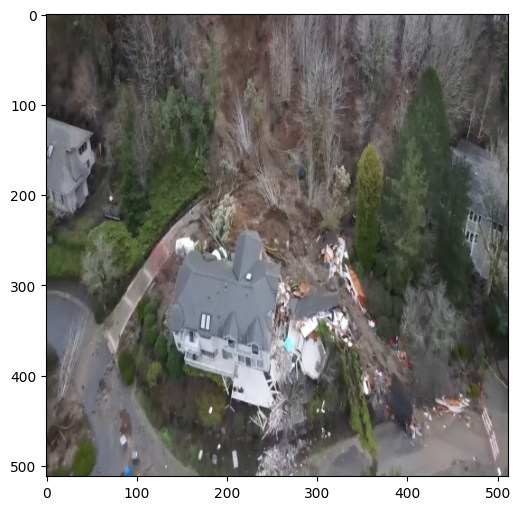

In [12]:
#Visualize image

seed= random.randint(0, 999)
print(f'{seed:03d}')
img = Image.open(f'{filepath}/IMG/train/train_0{seed:03d}.png')
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.show()

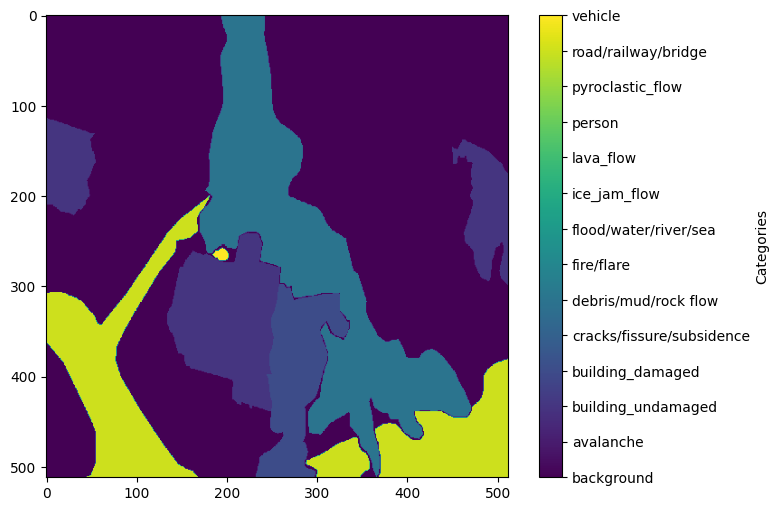

In [13]:
from matplotlib.colors import ListedColormap

# Define the colors for each value in the matrix
cmap = ListedColormap(colors)

mask = np.asarray(Image.open(f"{filepath}/GT_Updated/train/train_0{seed:03d}.png"))[:,:,0]
plt.figure(figsize=(8, 6))
plt.imshow(mask, vmin=0, vmax=13)
cbar = plt.colorbar(ticks=np.arange(14), label='Categories')
# cbar = plt.colorbar(ticks=np.arange(14), cmap = cmap, label='Categories')
cbar.ax.set_yticklabels(categories)
plt.show()

## Mobile former

In [14]:
import torch
from transformers import MobileViTV2ForSemanticSegmentation, MobileNetV2ImageProcessor, MobileViTV2Config
image_processor = MobileNetV2ImageProcessor()

configuration = MobileViTV2Config(image_size=512, num_labels=14)

model = MobileViTV2ForSemanticSegmentation(configuration)


In [ ]:
#create dataset
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np

class LPCVCDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root_dir, "IMG/train"))))
        self.masks = list(sorted(os.listdir(os.path.join(root_dir, "GT_Updated/train"))))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, "IMG/train", self.imgs[idx])
        mask_path = os.path.join(self.root_dir, "GT_Updated/train", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.asarray(mask)[:,:,0]
        mask = torch.as_tensor(mask, dtype=torch.int64)
        if self.transforms is not None:
            img = self.transforms(img)
        return img, mask

In [ ]:
#train test split 
from sklearn.model_selection import train_test_split
dataset = LPCVCDataset(filepath)
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

#train
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split

train_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

train_set = LPCVCDataset(filepath, transforms=train_transforms)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)

#test
test_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

test_set = LPCVCDataset(filepath, transforms=test_transforms)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False, num_workers=4)

#train
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

#